In [4]:
import models, losses, plotting_utils, multicoil_motion_simulator
from interlacer import utils

from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
from tqdm import tqdm

import mghGErecon as ge
import importlib

In [65]:
base_data_dir = '/vast/kmotion/users/nmsingh/dev/ismrm2022/multicoil_data_splits_obofix'
val_dir = os.path.join(base_data_dir,'test')

dir_list = os.listdir(val_dir)
dir_list = [file for file in dir_list if file[-4:]=='.npz']
random.shuffle(dir_list)
dir_list = dir_list[:200]


In [66]:
num_coils=44

In [67]:
column_names = ['Model','Example','Index','Theta','Motion Shot','Vertical Translation','Horizontal Translation','Input SSIM','Input PSNR','Output SSIM','Output PSNR']
results_df = pd.DataFrame(columns=column_names)


In [72]:
labels = ['Freq-Only','Image-Only','GRAPPA','Joint']
dirs = ['training/FINAL_nonlinearity/44-CONV_RESIDUAL-9-64-1-12-multicoil_ssim-FREQ-FREQ-3-piece-5000-6',
       'training/FINAL_nobn_recontinue/44-CONV_RESIDUAL-9-64-1-12-multicoil_ssim-IMAGE-IMAGE-relu-5000-6',
       '',
       'training/FINAL_interlacer_noshift/44-INTERLACER_RESIDUAL-9-64-1-6-multicoil_ssim-FREQ-FREQ-3-piece-5000-6',
       ]
epochs = [200,120,None,1850]
recons = []
num_coils = 44
freq_ssim = losses.multicoil_ssim('FREQ',num_coils)
freq_psnr = losses.multicoil_psnr('FREQ',num_coils)


for i in [3]:#range(3):
    if(i!=2):
        if(i==0):
            model = models.get_multicoil_conv_model(
                    (None, None, 2*num_coils),
                    '3-piece',
                    9,
                    64,
                    12,
                    num_coils)
        elif(i==1):
            model = models.get_multicoil_conv_model(
                    (None, None, 2*num_coils),
                    'relu',
                    9,
                    64,
                    12,
                    num_coils)
        elif(i==3):
            model = models.get_multicoil_interlacer_model(
                    (None, None, 2*num_coils),
                    '3-piece',
                    9,
                    64,
                    1,
                    6,
                    num_coils)


        lr = 1e-3
        model.compile(
            optimizer=tf.keras.optimizers.SGD(
                lr=lr),
            loss=freq_ssim,
            loss_weights=1)    

        epoch = str(epochs[i]).zfill(4)
        model.load_weights(dirs[i]+'/cp-'+epoch+'.ckpt')

    for j,ex in enumerate(tqdm(dir_list)):
        scan_data = ex.split('.')[0].split('_')[:4]
        scan_data.insert(2,'recon')
        scan_data.insert(0,'/vast/kmotion/data/data_anon/data_chelsea')
        sl = int(ex.split('.')[0].split('_')[4])

        ex_arch = np.load(os.path.join(val_dir, ex))
        angle = ex_arch['angle']
        angle = angle[0]-angle[1]
        
        num_pix = ex_arch['num_pix']
        horiz_trans = num_pix[1, 0]-num_pix[0, 0]
        vert_trans = num_pix[1, 1]-num_pix[0, 1]
        
        motion_shot = ex_arch['motion_shots'][1]

        res_info = np.load(os.path.join('/'.join(scan_data),'resolutioninfo.npz'))
        psx = res_info['pixelSizeX']
        psy = res_info['pixelSizeY']

        k_corrupt = ex_arch['k_corrupt']
        k_true = ex_arch['k_true']

        norm = np.max(plotting_utils.rss_image_from_multicoil_k(k_corrupt[0,:,:,:]).flatten())
        v_in = k_corrupt / norm
        v_out = k_true / norm
    
    
        if(i!=2):
            if 'Image' not in labels[i]:
                v_model = model(v_in)
            else:
                v_in_img = utils.convert_channels_to_image_domain(tf.convert_to_tensor(v_in))
                v_model_img = model(v_in_img)
                v_model = utils.convert_channels_to_frequency_domain(tf.convert_to_tensor(v_model_img))
        else:        
            v_grappa = ge.recon.recon_arc_kspace(utils.join_reim_channels(tf.convert_to_tensor(v_in))[0,...],'/'.join(scan_data))
            v_model = utils.split_reim_channels(tf.expand_dims(v_grappa,0))
        
        v_out = tf.convert_to_tensor(v_out)
        v_in = tf.convert_to_tensor(v_in)
        v_model = tf.convert_to_tensor(v_model)
            
        results_df = results_df.append({
            'Model': labels[i],
            'Example': ex,
            'Index': j,
            'Theta': angle,
            'Horizontal Translation': horiz_trans,
            'Vertical Translation': vert_trans,
            'Motion Shot': motion_shot,
            'Vertical Translation': vert_trans,
            'Horizontal Translation': horiz_trans,
            'Input SSIM': freq_ssim(v_out,v_in).numpy()[0],
            'Input PSNR': freq_psnr(v_out,v_in).numpy()[0],
            'Output SSIM': freq_ssim(v_out,v_model).numpy()[0],
            'Output PSNR': freq_psnr(v_out,v_model).numpy()[0]
        },ignore_index=True)

100%|██████████| 200/200 [04:15<00:00,  1.28s/it]


In [74]:
results_df.to_csv('test_results.csv')

In [5]:
results_df = pd.read_csv('test_results.csv')

In [6]:
input_ssim_list = list(results_df[results_df['Model']=='GRAPPA']['Output SSIM'])
seq = sorted(input_ssim_list,reverse=True)
sort_ssim_inds = [seq.index(v) for v in input_ssim_list]


In [7]:
results_df['SSIM'] = -1*results_df['Output SSIM']
results_df['Sorted Index'] = np.concatenate([item for item in [sort_ssim_inds] for i in range(4)])

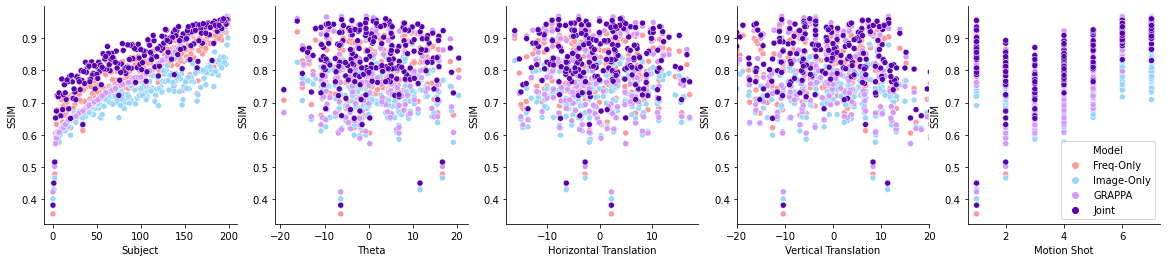

In [8]:
colors = ['#ff9999','#99d6ff','#d499ff','#5900b3']
this_cmap = sns.color_palette(colors,len(colors))
sns.set_palette(this_cmap)


fig, axes = plt.subplots(1,5,figsize=(20,4))



sp = sns.scatterplot(x='Sorted Index',y='SSIM',hue='Model',data=results_df,ax=axes[0])
sp.legend_.remove()
axes[0].set_xlabel('Subject')

sp = sns.scatterplot(
    data=results_df, x='Theta', y='SSIM', hue='Model', ax = axes[1]
)
sp.legend_.remove()

sp = sns.scatterplot(
    data=results_df, x='Horizontal Translation', y='SSIM', hue='Model', ax = axes[2]
)
sp.legend_.remove()
axes[3].set_xlim([-20,20])

sp = sns.scatterplot(
    data=results_df, x='Vertical Translation', y='SSIM', hue='Model', ax = axes[3]
)
sp.legend_.remove()
axes[3].set_xlim([-20,20])

sp = sns.scatterplot(
    data=results_df, x='Motion Shot', y='SSIM', hue='Model', ax = axes[4]
)

for i in range(5):
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
        

In [ ]:
162